# Seattle AirBnB Market Analysis
## My main objective and the business question that I would like to answer is:
 
- Im thinking whether should I invest money into airbnb

#### To answer that question, I will be using top-down approach to perform the data analysis and break the analysis in following parts:

1. Do investing airbnb in Seattle worth it nowadays?
   
2. What property and neighbourhood is worth investing in?
   
3. What is the features or things that people care the most if I own a property in Seattle?

## Import Library

In [32]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [33]:
def read_file(file):
    
    return pd.read_csv(file)
    

calendar_data = read_file('calendar.csv') 
listings_data = read_file('listings.csv')
reviews_data = read_file('reviews.csv')

# Data Preprocessing

- Convert some columns to correct format as they have been set as incorrect format due to symbol in columns

In [37]:
def cleaning_data(df):
    for ch in ['%','$',',']:
        df = df.map(lambda x: x.replace(ch, ''))

    return df

In [38]:
col = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people','host_acceptance_rate','host_response_rate']

listings_data[col] = listings_data[col].astype(str).apply(cleaning_data).astype(float)
calendar_data[['price']] = calendar_data[['price']].astype(str).apply(cleaning_data).astype(float)

calendar_data['date'] = pd.to_datetime(calendar_data.date)
reviews_data['date'] = pd.to_datetime(reviews_data.date)

## Check missing values

In [39]:
def print_missing_pct(str,df,n):
    print(str)
    print((df.isnull().sum(axis=0).sort_values(ascending=False)/len(df)).head(n))
    print()


# Listing data
print_missing_pct('Listing Data Missing Value Percentage',listings_data,10)

# Review data
print_missing_pct('Review Data Missing Value Percentage',reviews_data,10)

# calendar data
print_missing_pct('Calendar Data Missing Value Percentage',calendar_data,10)

Listing Data Missing Value Percentage
license                  1.000000
square_feet              0.974594
monthly_price            0.602672
security_deposit         0.511262
weekly_price             0.473808
notes                    0.420639
neighborhood_overview    0.270299
cleaning_fee             0.269775
transit                  0.244631
host_about               0.224987
dtype: float64

Review Data Missing Value Percentage
comments         0.000212
reviewer_name    0.000000
reviewer_id      0.000000
date             0.000000
id               0.000000
listing_id       0.000000
dtype: float64

Calendar Data Missing Value Percentage
price         0.32939
available     0.00000
date          0.00000
listing_id    0.00000
dtype: float64



In [40]:
# When the listings is not available, some security_deposit and cleaning fee rows have been stored as NaN value
# Hence NaN value has been replaced by 0 

listings_data[['security_deposit','cleaning_fee']] = listings_data[['security_deposit','cleaning_fee']].fillna(0)

# Keep those columns that have at least over 60% non NaN values
# Weekly and monthly price have been dropped too since price already contains the same information

threshold = len(listings_data)*0.6
listings_data = listings_data.dropna(thresh=threshold, axis=1 )

# drop columns that contain one unique value as it also doesnt help in contributing any insight as well

listings_data = listings_data.loc[:,listings_data.apply(pd.Series.nunique) != 1]

### Fill in those missing value 

#### Three strategies that have been used to fill in those missing values
1. Fill with mean 
    - Continuous variables
2. Fill with most frequent value 
    - Binary variables
    - These are the columns that have only one or two missing values, so I personally think that it is much more ideal to fill in most frequent value which would have the most minimum effect on distorting the results
3. Fill with Unknown
    - Binary variables
    - The missing values of these columns are quite high, so I decide to fill in with 'Unknown' so that the tree-based model are able to splitting them with the other values in corresponding columns.


In [41]:
from sklearn.preprocessing import Imputer

fill_mean_list = ['review_scores_checkin','review_scores_accuracy','review_scores_value',
                  'host_acceptance_rate','review_scores_cleanliness','review_scores_location',
                  'review_scores_communication', 'bedrooms','host_response_rate','bathrooms',
                  'beds','review_scores_rating','reviews_per_month','review_scores_value',
                  'review_scores_location','review_scores_communication','review_scores_rating',]

fill_mfreq_list = ['host_total_listings_count','host_listings_count','host_identity_verified',
                   'host_has_profile_pic','host_is_superhost','property_type','host_response_time']

binary_list = ['host_identity_verified','host_has_profile_pic','host_is_superhost']

decimal_list = ['host_response_rate','host_acceptance_rate']

# drop list
drop_url_col=[col for col in listings_data.columns.values if 'url' in col]
drop_col = ['description','neighborhood_overview','host_id','street',
            'neighbourhood_cleansed','neighbourhood','smart_location', 
            'latitude', 'longitude', 'space','host_since',
            'zipcode','summary','first_review','last_review','host_name','transit','host_about',
            'host_neighbourhood']

def data_preprocessing(df,mean_list,freq_list,binary_list,decimal_list,drop_url_col,drop_col):
  
    # imputer
    imp_mean = Imputer(missing_values='NaN', strategy='mean', axis=0)

    # fill with mean
    imp_mean = imp_mean.fit(df[fill_mean_list])
    df[fill_mean_list] = imp_mean.transform(df[mean_list])

    # fill with most frequent value
    df[freq_list] = df[freq_list].fillna(df[freq_list].mode().iloc[0])
    
    # convert into decimal
    df[decimal_list] = df[decimal_list]/100
    
    # convert to binary value
    df[binary_list] = np.where(df[binary_list] == 't', 1, 0)
    
    # drop columns
    df = df.drop(drop_url_col,axis=1)
    df = df.drop(drop_col,axis=1)


data_preprocessing(listings_data,fill_mean_list,fill_mfreq_list,binary_list,decimal_list,drop_url_col,drop_col)

/Users/andri.sumitro/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)



## Question 1. Do investing airbnb in Seattle worth it nowadays?
   - High level analysis on Seattle Airbnb market
   - examine if the short-rental market is still worth to invest in as we do not want to invest in when the market has reached its peak or market downturn.

In [42]:
# minimum, maximum and average price for listing
print('Minimum rental price in Seattle Airbnb is %d$.' % (listings_data['price'].min()))
print('Maximum rental price Seattle Airbnb is %d$' % (listings_data['price'].max()))
print('Average rental price Seattle Airbnb is %d$.' % (listings_data['price'].mean()))

Minimum rental price in Seattle Airbnb is 20$.
Maximum rental price Seattle Airbnb is 1000$
Average rental price Seattle Airbnb is 127$.


###  Popularity of Airbnb in seattle
- It is worth to have a look at the growth in seattle airbnb market, so that we could have an idea if there is still a potential growth in it because we do not want to invest in airbnb business if the market has reached the peak and slowing down dramatically. 

In [62]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

def plot(df,x,y,title,kind='line'):
    
    df.plot(x=x, y=y,title=title,kind=kind)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

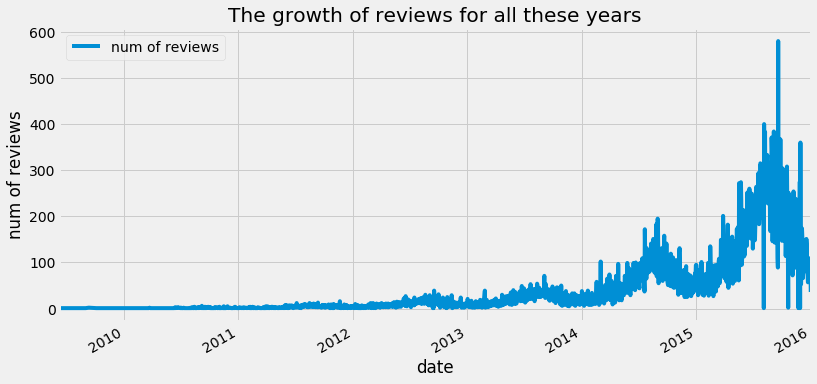

In [63]:
num_review = reviews_data.groupby('date').id.count().reset_index()
num_review.rename(columns={'id':'num of reviews'},inplace=True)

plot(num_review,'date','num of reviews','The growth of reviews for all these years')

- It can be seen that the number of unique listings receiving reviews are increasing exponentitally, indicating that the huge amount of people visiting seattle and they are much more prefer to stay in Airbnb although it is decreasing in 2016
- Note that there is a seasonal pattern in every year, like a drop at the beginning of every year, so the drop in 2016 is not actually mean that it is decreasing
- Hence investing in seattle airbnb business is an ideal option to be considered and there is still have a room for growth in it.

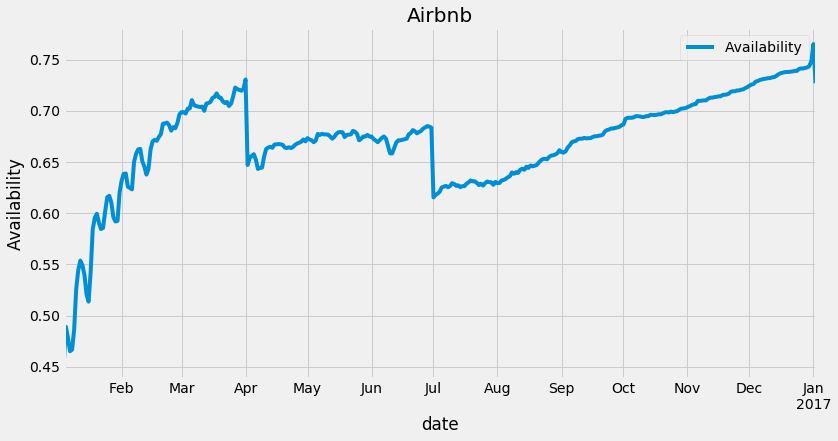

In [64]:
calendar = calendar_data[['date', 'available']].copy()
calendar['Availability'] = calendar.available.map( lambda x: 1 if x == 't' else 0)
calendar = calendar.groupby('date')['Availability'].mean().reset_index()

plot(calendar,'date','Availability','Airbnb')

- seems like the busiest months are Jan 2016, april 2016 and July-Sep 2016 (summer)

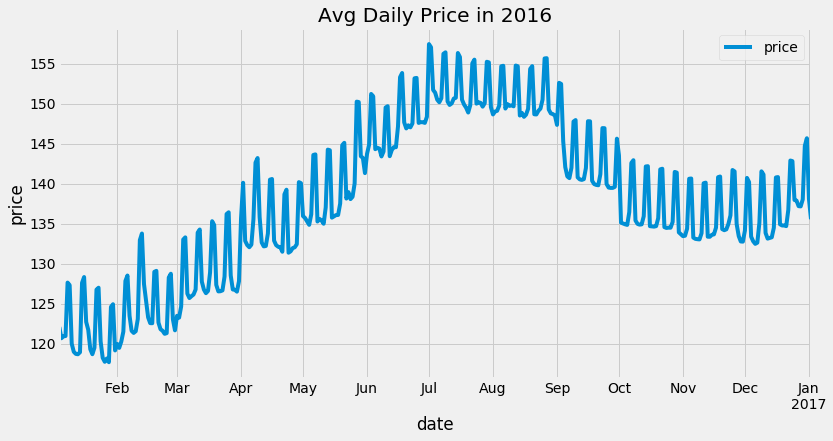

In [65]:
mean_of_month = calendar_data.groupby(calendar_data['date'],sort=False).price.mean().reset_index()

plot(mean_of_month,'date','price','Avg Daily Price in 2016')

- Airbnb price in seattle increases from July to September. Those three months are the peak throughout the years compare to the rest of the months. This is probably most of the tourists visit Seattle during summer.
- Hence having listings available throughout the summer will help to generate much more revenue

## Question 2. What property and neighbourhood is worth investing in?
   - help us to determine which property type and neighbourhood should invest in by examining revenue and occupancy rate
   
#### Our main objective is to find out which area and what type of property should we invest in:
Normally, when it comes to rental property investment, the following two metrics are the one that has to be look at:

1. Revenue from rental income
    - Rental income is the most important metrics that we are going to see if airbnb business is worth investing in
2. Occupancy rate 
    - Apart from revenue, occupancy rate is another metrics should be keep an eyes on, because it is one of the important factor that determine if you are going to succeed in airbnb business. For example, if your property occupancy rate is over 50%, which might an indication of your success and stability in airbnb business
    
Before calculating the metrics above, we could perform EDA to get a glimpse of seattle airbnb data 

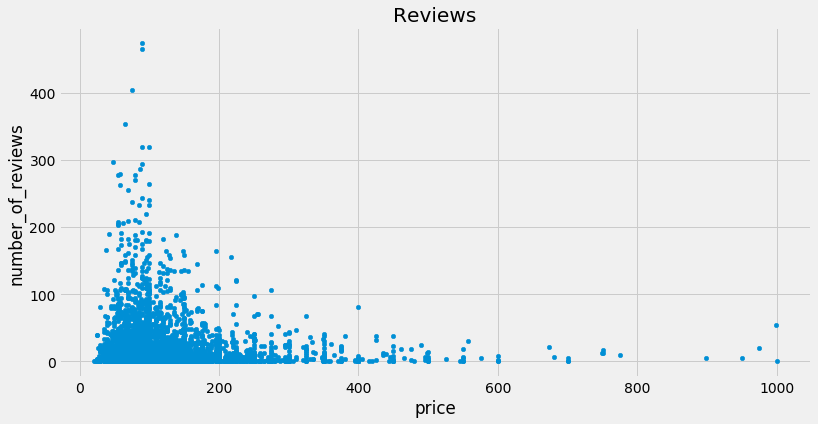

In [66]:
price_review = listings_data[['number_of_reviews', 'price']].sort_values(by = 'price')
plot(price_review,'price','number_of_reviews','Reviews','scatter')

The graph shows that most of the reviews stick below 600 and number of reviews quickly declines as the price goes up, probably because below 600 is the price range that is considered as reasonable and acceptable. Hence I would be focus on analysing those properties with below 600 rental price 

In [67]:
listings_new = listings_data[listings_data.price <= 600].copy()

### Calculating annual revenue and occupancy rate

#### Since annual occupancy rate and revenues are not provided in the dataset,we could estimate them with some columns below:

- reviews_per_month: insights into frequency of visits of the listing
- min_nights: indicator of minimum stay length, to be used with the number of monthly reviews
- availability_365: an indicator of the total number of days the listing is available for during the year 
- price : the amount that people have to pay for renting property


#### 1. Revenue

revenue = ((reviews_per_month x min_nights x price) x 12)
    
#### 2. Occupancy Rates

occupancy = ((reviews_per_month x min_nights) x 12) / availability_365


These will serve as a conservative estimate of the revenue, since it is likely that properties will 
have more bookings than reviews and guests are also likely to stay at least longer than the minimum number of 
nights required.

In [68]:
listings_new['occupancy_rate_yrly'] = (listings_new.reviews_per_month * listings_new.minimum_nights * 12)/listings_new.availability_365
listings_new['estd_revenue_yrly'] = listings_new.reviews_per_month * listings_new.minimum_nights * listings_new.price * 12

In [69]:
listings_new = listings_new[(listings_new.occupancy_rate_yrly != np.inf) & (listings_new.occupancy_rate_yrly <= 1)]
airbnb_invest = listings_new.groupby(['neighbourhood_group_cleansed','property_type']).agg({'price':'mean',
                                                                                            'occupancy_rate_yrly':'mean',
                                                                                            'estd_revenue_yrly':'mean',
                                                                                            'id':'count'}).reset_index()

In [70]:
# let's say I want to invest in apartment and condominium as they are more easily taking care of

airbnb_down = airbnb_invest[(airbnb_invest.property_type == 'Apartment') | 
              (airbnb_invest.property_type == 'Condominium')].\
               sort_values(by='estd_revenue_yrly',ascending=False).head(10)

airbnb_down.rename(columns={'neighbourhood_group_cleansed':'neighbourhood',
                            'property_type':'property type',
                            'occupancy_rate_yrly':'occupancy rate',
                            'estd_revenue_yrly':'estd revenue',
                            'id':'count'},inplace=True)
airbnb_down.reset_index(inplace=True)


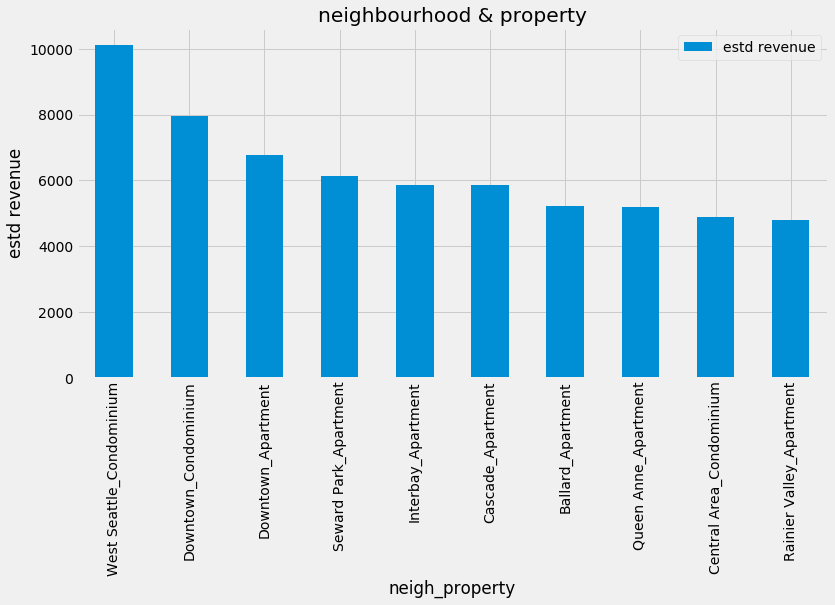

In [71]:
airbnb_down['neigh_property'] = airbnb_down['neighbourhood'] + "_" + airbnb_down['property type']

plot(airbnb_down,'neigh_property','estd revenue','neighbourhood & property','bar')

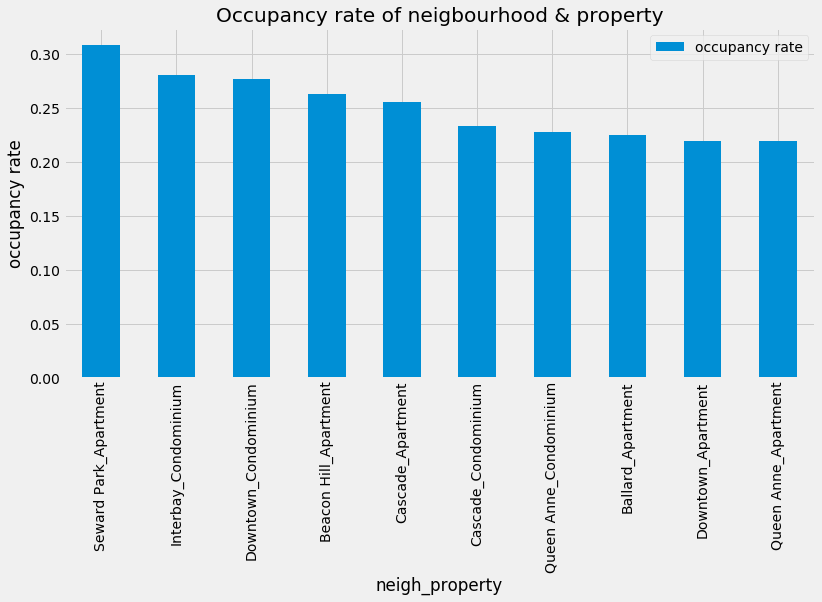

In [72]:
airbnb_occ = airbnb_invest[(airbnb_invest.property_type == 'Apartment') | 
              (airbnb_invest.property_type == 'Condominium')].\
               sort_values(by='occupancy_rate_yrly',ascending=False).head(10)
airbnb_occ.rename(columns={'neighbourhood_group_cleansed':'neighbourhood',
                            'property_type':'property type',
                            'occupancy_rate_yrly':'occupancy rate',
                            'estd_revenue_yrly':'estd revenue',
                            'id':'count'},inplace=True)
airbnb_occ.reset_index()

airbnb_occ['neigh_property'] = airbnb_occ['neighbourhood'] + "_" + airbnb_occ['property type']

plot(airbnb_occ,'neigh_property','occupancy rate','Occupancy rate of neigbourhood & property','bar')

#### Interestingly, I found out that if a condominium generate a descent revenue if it satisfies these following conditions:
- beds >= 2
- bedrooms >= 1 
- bathrooms > 1
- host_response_time == 'within an hour'

#### Findings
- 4 out of 33 condominium have reached these criteria with good occupancy rate I would say, this might an indication that there is still a potential opportunity to squeeze in 
- if you mimic all the good side of them, we could probably get $33052.43 esimated revenue and 0.3257 occupancy rate by averaging 4 of them.

In [73]:
#Break it down again into condominium
Downtown_condo = listings_new[(listings_new.property_type == 'Condominium') &
                              (listings_new.neighbourhood_group_cleansed == 'Downtown')]

# have a look at these condominiums that satisfy these condition
Downtown_condo = Downtown_condo[(Downtown_condo.beds >= 2) & 
                                (Downtown_condo.bedrooms >= 1) & 
                                (Downtown_condo.bathrooms > 1) & 
                                (Downtown_condo.host_response_time == 'within an hour')]\
                                [['neighbourhood_group_cleansed','property_type','price','occupancy_rate_yrly','estd_revenue_yrly','id']]

Downtown_condo.rename(columns={'neighbourhood_group_cleansed':'neighbourhood',
                            'property_type':'property type',
                            'occupancy_rate_yrly':'occupancy rate',
                            'estd_revenue_yrly':'estd revenue',
                            'id':'count'},inplace=True)

Downtown_condo.reset_index(inplace=True)

Downtown_condo.groupby(['neighbourhood'])[['occupancy rate','estd revenue']].mean()

,occupancy rate,estd revenue
neighbourhood,,
Downtown,0.325702,33052.5845


# Conclusion 


#### Neighbourhood
- I would choose to invest in Downtown as there are where most of tourists that would like to stay from the number of listings of all property. 
- In addition, with huge gap of the number of listings between Downtown and the other neighbourhood, it still can achieve high occupancy rates and revenue

#### Property type 
- I would choose to invest in condominium although the number of condominium being rented is not as big as apartment.
- First of all, I still see that there is a huge potential of it as it is not very competitive like apartment (total 404).
- Secondly is if I am assuming I will make $33052.43 esimated revenue and 0.3257 occupancy rate from condominium, there are only 10 out of 404 that have exceeded, so the probability of making higher ROI from apartment is quite low.

## Question 3. What is the features or things that people care the most if I own a property in Seattle?

## Analysis on textual data
#### Features that will be used:
1. Name in listings data 
2. comments in review data
3. Anemeties in listings data

In [74]:
from nltk.corpus import stopwords
import nltk
nltk.download("punkt") 
nltk.download('wordnet')
import string
from wordcloud import WordCloud,ImageColorGenerator

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andri.sumitro/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andri.sumitro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [75]:
def wordcloud(df,col_name, save_file_name):

    punctuations = string.punctuation
    english_stopwords = stopwords.words("english")
    text=''
    for index, row in df.iterrows():
        text += " "
        text += row[col_name]
    text = nltk.word_tokenize(text)
    
    # Remove, punctuations, stopwords and numbers
    text = [word.lower() for word in text if word not in punctuations \
                 if not word.isdigit() if word not in english_stopwords]
    wnl = nltk.WordNetLemmatizer()
    text = [wnl.lemmatize(word) for word in text]
    text = ' '.join(text)
    name_wordcloud = WordCloud(width=1500,height=1000, background_color='white',\
                           max_words=200, random_state=100).generate(text)
    plt.figure(figsize=(15,8))
    plt.imshow(name_wordcloud)
    plt.axis("off")
    plt.show()
    name_wordcloud.to_file(save_file_name)

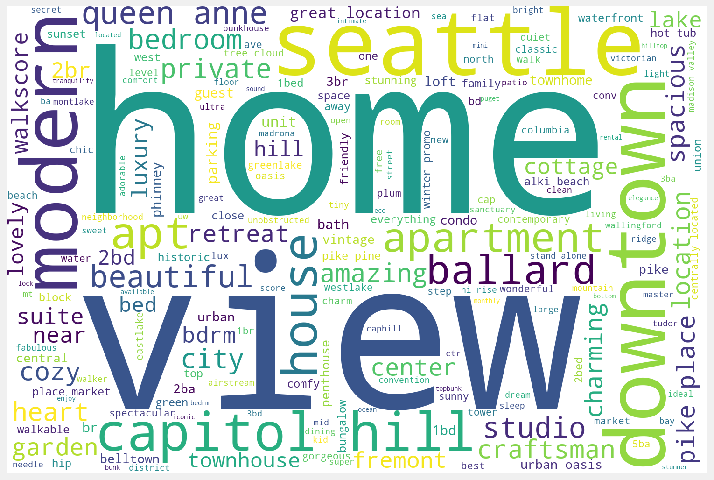

In [76]:
# Analyse the name of top 20% revenue and high review listings

top_20_pct_list = listings_new[(listings_new.estd_revenue_yrly >= np.percentile(listings_new.estd_revenue_yrly,90))]# &
                               #(listings_new.review_scores_rating > 90)]

wordcloud(top_20_pct_list,'name','top_20_pct_wordcloud.jpeg')

- It appears that mentioning view, modern, downtown, lake in your listing name is likely to increase your property's exposure and attract the viewer’s attention

### Analysis on comments in reviews dataset

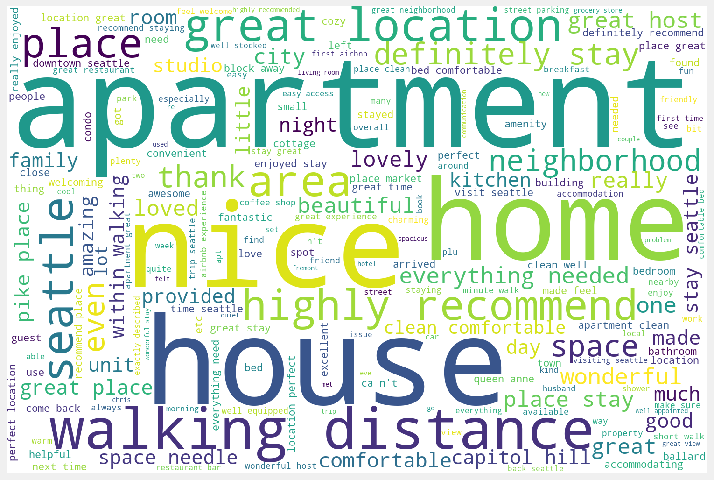

In [77]:
top_score_comment = top_20_pct_list[top_20_pct_list.review_scores_rating > 70]
top_score_comment = pd.merge(top_score_comment,reviews_data,left_on='id',right_on='listing_id',how='inner')
top_score_comment = top_score_comment.fillna('Unknown')

wordcloud(top_score_comment,'comments', 'top_comment_wordcloud.jpeg')

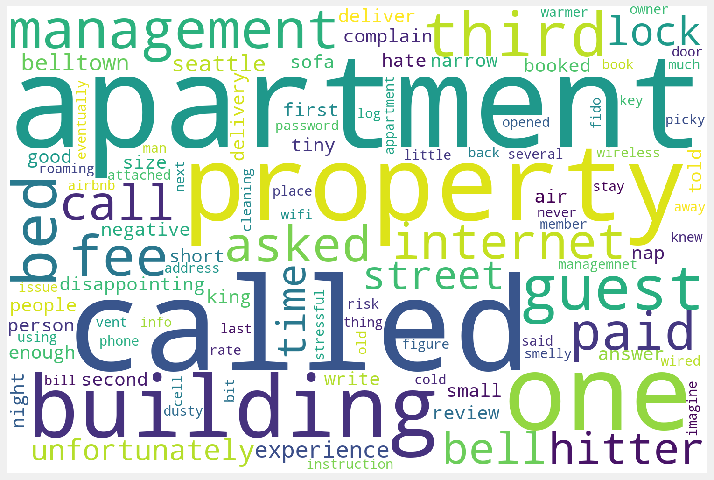

In [78]:
bottom_score_comment = listings_data[listings_data.review_scores_rating < 30]
bottom_score_comment = pd.merge(bottom_score_comment,reviews_data,left_on='id',right_on='listing_id',how='inner')

wordcloud(bottom_score_comment,'comments', 'top_comment_wordcloud.jpeg')

#### Top Score Listings 
- It can be seen that the most talked about words are "great location", "walking distance" and "highly recommended", which mean that lot of people are happy staying around city, which they care about most are location that are near to great foods and tourist attractions as well as comfortable place to stay.

#### Bottom Score Listings 
- These are the listings that has been commented as smelly, tiny, dusty. Obviously, the places might not have managed very well.
    
With Top and bad score listings review, we know more about what are the most tourists that are looking for (location, walking distance, tourist attraction, restaurant and cleanliness)

### Analysis on Amenities

- Anemeties appear to be one of the important factors that people might live in your property
- The objective of this is to find out what are the common anemeties that most of the listing have and also find out what are the anemeties that appears in high end and low end property

In [79]:
#remove all the buckets,parenthesis and punctuation
listings_data['amenities'] = listings_data.amenities.str.replace("[{}]", "").str.replace('"', "")
listings_data['amenities'].head()

0    TV,Cable TV,Internet,Wireless Internet,Air Con...
1    TV,Internet,Wireless Internet,Kitchen,Free Par...
2    TV,Cable TV,Internet,Wireless Internet,Air Con...
3    Internet,Wireless Internet,Kitchen,Indoor Fire...
4    TV,Cable TV,Internet,Wireless Internet,Kitchen...
Name: amenities, dtype: object

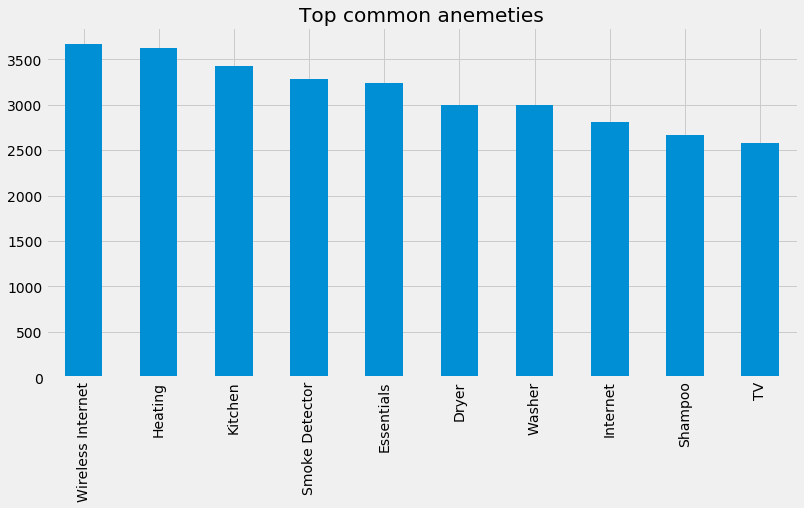

In [80]:
anemeties_df = pd.Series(np.concatenate(listings_data.amenities.map(lambda amns: amns.split(",")))).value_counts().head(10)
anemeties_df.plot(kind='bar',title='Top common anemeties')